<a href="https://colab.research.google.com/github/ANS1514/Projects_in_AI-ML/blob/main/hw5pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
from google.colab import files
import os
import pandas as pd
from zipfile import ZipFile

uploaded = files.upload()

for fname in uploaded.keys():
    if fname.endswith(".zip"):
        with ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall()

base_dir = os.getcwd()

folders = {
    'healthy_corals': 'healthy',
    'bleached_corals': 'bleached'
}

data = []

for folder, label in folders.items():
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg')):
            data.append({'image': filename, 'label': label})

df = pd.DataFrame(data)
print(df.head())


                          image    label
0   4997819967_364d2bfd89_o.jpg  healthy
1    847115147_17aafa5859_b.jpg  healthy
2   5365142795_f3f4061030_o.jpg  healthy
3  15048176469_d1bcb75417_b.jpg  healthy
4   9511909153_ea27e2ec63_o.jpg  healthy


In [ ]:
class CoralDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.base_dir, label + "_corals", img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = CoralDataset(df, base_dir, transform)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=2
)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, z_dim=128):
        super(VAE, self).__init__()
        self.z_dim = z_dim

        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 -> 8x8
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, z_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, z_dim)

        # Decoder
        self.fc_decode = nn.Linear(z_dim, 128 * 8 * 8)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # 32x32 -> 64x64
            nn.Sigmoid(),  # pixel values between 0 and 1
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 8, 8)
        return self.dec_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [ ]:
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

model = VAE().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 1000
for epoch in range(epochs):
    total_loss = 0
    for imgs in dataloader:
        imgs = imgs.to('cuda')
        recon, mu, logvar = model(imgs)
        loss = vae_loss(imgs, recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset):.4f}")


Epoch 1, Loss: 681.8959
Epoch 2, Loss: 518.4362
Epoch 3, Loss: 460.4074
Epoch 4, Loss: 396.8763
Epoch 5, Loss: 349.1632
Epoch 6, Loss: 326.4457
Epoch 7, Loss: 311.6233
Epoch 8, Loss: 303.6738
Epoch 9, Loss: 296.5865
Epoch 10, Loss: 291.8109
Epoch 11, Loss: 286.6035
Epoch 12, Loss: 282.6949
Epoch 13, Loss: 278.3256
Epoch 14, Loss: 275.9965
Epoch 15, Loss: 270.3967
Epoch 16, Loss: 265.9233
Epoch 17, Loss: 263.3403
Epoch 18, Loss: 259.4790
Epoch 19, Loss: 256.7853
Epoch 20, Loss: 253.7433
Epoch 21, Loss: 250.7999
Epoch 22, Loss: 248.8100
Epoch 23, Loss: 246.9519
Epoch 24, Loss: 245.5292
Epoch 25, Loss: 245.7321
Epoch 26, Loss: 243.5489
Epoch 27, Loss: 239.3475
Epoch 28, Loss: 239.0899
Epoch 29, Loss: 236.9934
Epoch 30, Loss: 234.0757
Epoch 31, Loss: 231.7260
Epoch 32, Loss: 230.7145
Epoch 33, Loss: 228.9009
Epoch 34, Loss: 226.6203
Epoch 35, Loss: 226.2721
Epoch 36, Loss: 225.0788
Epoch 37, Loss: 225.8422
Epoch 38, Loss: 222.8228
Epoch 39, Loss: 221.0741
Epoch 40, Loss: 220.4578
Epoch 41,

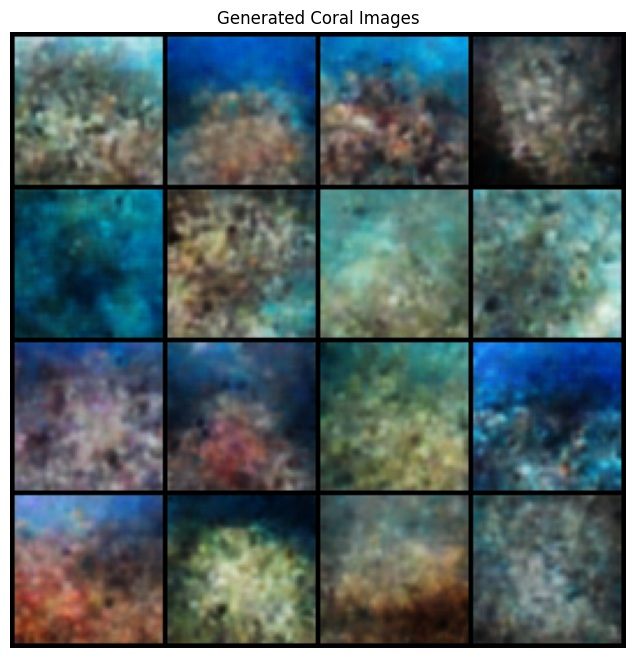

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(16, model.z_dim).to('cuda')
    generated = model.decode(z).cpu()

    grid = make_grid(generated, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Coral Images")
    plt.show()


In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

Starting Training Loop...
1/1000 Loss_D: 1.4470 Loss_G: 4.3748 
2/1000 Loss_D: 0.1604 Loss_G: 12.3209 
3/1000 Loss_D: 0.4150 Loss_G: 11.4208 
4/1000 Loss_D: 0.1433 Loss_G: 6.8807 
5/1000 Loss_D: 0.2048 Loss_G: 5.0241 
6/1000 Loss_D: 1.4041 Loss_G: 2.6896 
7/1000 Loss_D: 1.3902 Loss_G: 5.6521 
8/1000 Loss_D: 0.4953 Loss_G: 2.2038 
9/1000 Loss_D: 0.4074 Loss_G: 5.0413 
10/1000 Loss_D: 0.3131 Loss_G: 3.2343 
11/1000 Loss_D: 0.1985 Loss_G: 4.1247 
12/1000 Loss_D: 2.0773 Loss_G: 1.9788 
13/1000 Loss_D: 0.5306 Loss_G: 2.0224 
14/1000 Loss_D: 0.1684 Loss_G: 4.0367 
15/1000 Loss_D: 0.5649 Loss_G: 2.2169 
16/1000 Loss_D: 0.2406 Loss_G: 1.7504 
17/1000 Loss_D: 0.5342 Loss_G: 3.8673 
18/1000 Loss_D: 0.6641 Loss_G: 7.0214 
19/1000 Loss_D: 0.7217 Loss_G: 7.5274 
20/1000 Loss_D: 0.4865 Loss_G: 3.9678 
21/1000 Loss_D: 0.5210 Loss_G: 2.6024 
22/1000 Loss_D: 0.7438 Loss_G: 8.4334 
23/1000 Loss_D: 1.0706 Loss_G: 2.4806 
24/1000 Loss_D: 0.7158 Loss_G: 5.6129 
25/1000 Loss_D: 0.2180 Loss_G: 4.0672 
26/100

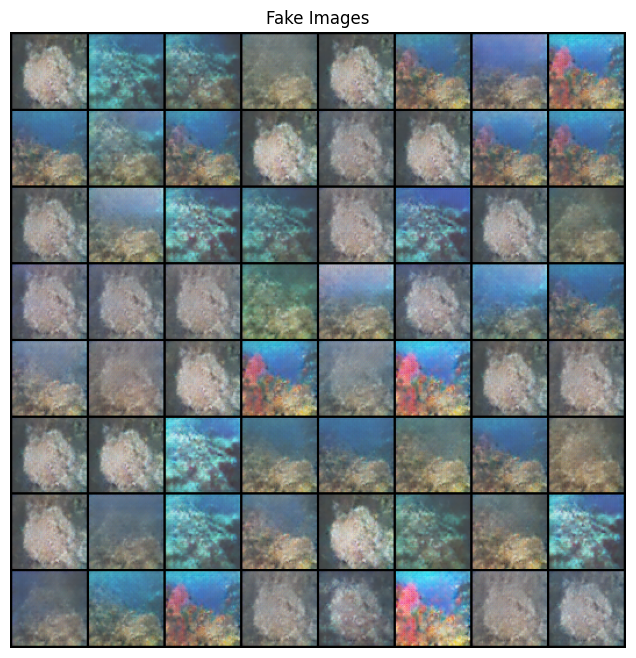

In [ ]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)


criterion = nn.BCELoss()

# Hyperparameters
lr = 0.0002
beta1 = 0.5
nz = 100

# Create optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

num_epochs = 1000
real_label = 1.
fake_label = 0.

img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ## Train with real
        netD.zero_grad()
        real_images = data.to(device, non_blocking=True)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 50 == 0:
            print(f'{epoch+1}/{num_epochs} '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} ')

    # Check progress
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-1].permute(1, 2, 0))
plt.show()